In [24]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from data import CIFData, collate_pool, get_train_val_test_loader
from model import CrystalGraphConvNet 

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
np.random.seed(123)

In [26]:
dataset = CIFData(root_dir='F:\College\Research Paper Work\Superconductor-Tc-Prediction\work\CGCNN\data', max_num_nbr=20, radius=15,
                  dmin=0, step=0.2, random_seed=123)


In [27]:
def collate_batch(batch):
    batch_atom_fea = []
    batch_nbr_fea = []
    batch_nbr_fea_idx = []
    batch_crystal_atom_idx = []
    batch_target = []
    batch_cif_ids = []

    base_idx = 0
    for crystal_idx, ( (atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx), target, cif_id) in enumerate(batch):
        n_i = atom_fea.shape[0]  # Number of atoms in this crystal

        batch_atom_fea.append(atom_fea)
        batch_nbr_fea.append(nbr_fea)
        batch_nbr_fea_idx.append(nbr_fea_idx)

        # For each atom in this crystal, assign crystal_idx
        batch_crystal_atom_idx.extend([crystal_idx] * n_i)

        batch_target.append(target)
        batch_cif_ids.append(cif_id)

        base_idx += n_i

    return (
        torch.cat(batch_atom_fea, dim=0),
        torch.cat(batch_nbr_fea, dim=0),
        torch.cat(batch_nbr_fea_idx, dim=0),
        torch.LongTensor(batch_crystal_atom_idx),  # length = total atoms in batch
    ), torch.stack(batch_target), batch_cif_ids


In [28]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 64
num_workers = 4
pin_memory = True  # or False depending on your CUDA usage

# Use ratio-based split (can also specify fixed sizes instead)
train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset=dataset,
    collate_fn=collate_batch, 
    batch_size=batch_size,
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    test_ratio=test_ratio,
    num_workers=0,
    pin_memory=pin_memory,
    train_size=None,  # or set to exact int like 4618 (0.8 * 5773)
    val_size=None,
    test_size=None,
    return_test=True
)

In [29]:
from model import CrystalGraphConvNet

model = CrystalGraphConvNet(
    orig_atom_fea_len=4,
    nbr_fea_len=3,
    atom_fea_len=64,
    n_conv=3,
    h_fea_len=128,
    n_h=1,
    classification=False  # change to True if you’re doing classification
)
model.to(device)


CrystalGraphConvNet(
  (embedding): Linear(in_features=4, out_features=64, bias=True)
  (convs): ModuleList(
    (0-2): 3 x ConvLayer(
      (fc_full): Linear(in_features=131, out_features=128, bias=True)
      (sigmoid): Sigmoid()
      (softplus1): Softplus(beta=1.0, threshold=20.0)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (softplus2): Softplus(beta=1.0, threshold=20.0)
    )
  )
  (conv_to_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv_to_fc_softplus): Softplus(beta=1.0, threshold=20.0)
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [30]:
criterion = nn.MSELoss()  # for regression tasks
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [31]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for (atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx), target, cif_id in train_loader:
        # Move tensors to device
        atom_fea = atom_fea.to(device)
        nbr_fea = nbr_fea.to(device)
        nbr_fea_idx = nbr_fea_idx.to(device)
        crystal_atom_idx = crystal_atom_idx.to(device)
        target = target.to(device)

        # Flatten target to shape [batch_size]
        target = target.view(-1)

        optimizer.zero_grad()
        output = model(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)

        # Flatten output to match target shape
        output = output.view(-1)

        # Compute loss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device, return_preds=False):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for (atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx), target, cif_id in val_loader:
            # move tensors to device
            atom_fea = atom_fea.to(device)
            nbr_fea = nbr_fea.to(device)
            nbr_fea_idx = nbr_fea_idx.to(device)
            crystal_atom_idx = crystal_atom_idx.to(device)
            target = target.to(device).view(-1)

            output = model(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)
            output = output.view(-1)

            loss = criterion(output, target)
            total_loss += loss.item()

            if return_preds:
                all_preds.append(output.cpu())
                all_targets.append(target.cpu())

    avg_loss = total_loss / len(val_loader)

    if return_preds:
        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()
        return avg_loss, all_preds, all_targets
    else:
        return avg_loss



In [39]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, all_preds, all_targets = validate(model, val_loader, criterion, device, return_preds=True)
    
    r2 = r2_score(all_targets, all_preds)
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"R² Score: {r2:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")



Epoch 1/100
Train Loss: 256.5153 | Val Loss: 230.7851
R² Score: 0.2828 | MSE: 255.0758 | RMSE: 15.9711

Epoch 2/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 246.5211 | Val Loss: 221.9547
R² Score: 0.3235 | MSE: 240.5939 | RMSE: 15.5111

Epoch 3/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 244.6754 | Val Loss: 1384.1243
R² Score: -3.3162 | MSE: 1535.0496 | RMSE: 39.1797

Epoch 4/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 251.0188 | Val Loss: 201.7416
R² Score: 0.3722 | MSE: 223.2865 | RMSE: 14.9428

Epoch 5/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 239.6678 | Val Loss: 481.2600
R² Score: 0.1073 | MSE: 317.4946 | RMSE: 17.8184

Epoch 6/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 247.7026 | Val Loss: 253.6129
R² Score: 0.3012 | MSE: 248.5139 | RMSE: 15.7643

Epoch 7/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 233.3770 | Val Loss: 259.5149
R² Score: 0.2081 | MSE: 281.6256 | RMSE: 16.7817

Epoch 8/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 242.1747 | Val Loss: 278.0402
R² Score: 0.1329 | MSE: 308.3972 | RMSE: 17.5612

Epoch 9/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 228.9191 | Val Loss: 1444.4848
R² Score: -1.9143 | MSE: 1036.4727 | RMSE: 32.1943

Epoch 10/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 243.7102 | Val Loss: 290.8550
R² Score: 0.3476 | MSE: 232.0136 | RMSE: 15.2320

Epoch 11/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 222.3175 | Val Loss: 206.8973
R² Score: 0.3586 | MSE: 228.1179 | RMSE: 15.1036

Epoch 12/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 226.5087 | Val Loss: 416.1764
R² Score: -0.2697 | MSE: 451.5757 | RMSE: 21.2503

Epoch 13/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 227.6833 | Val Loss: 217.0734
R² Score: 0.3359 | MSE: 236.1745 | RMSE: 15.3680

Epoch 14/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 225.8579 | Val Loss: 246.3622
R² Score: 0.2564 | MSE: 264.4548 | RMSE: 16.2621

Epoch 15/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 225.5735 | Val Loss: 244.6012
R² Score: 0.2588 | MSE: 263.6137 | RMSE: 16.2362

Epoch 16/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 224.5986 | Val Loss: 267.7896
R² Score: 0.1658 | MSE: 296.6964 | RMSE: 17.2249

Epoch 17/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 219.1043 | Val Loss: 211.2883
R² Score: 0.3799 | MSE: 220.5461 | RMSE: 14.8508

Epoch 18/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 220.7284 | Val Loss: 191.7363
R² Score: 0.4071 | MSE: 210.8759 | RMSE: 14.5216

Epoch 19/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 213.6157 | Val Loss: 217.7583
R² Score: 0.3209 | MSE: 241.5182 | RMSE: 15.5409

Epoch 20/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 213.1945 | Val Loss: 209.2953
R² Score: 0.3499 | MSE: 231.1915 | RMSE: 15.2050

Epoch 21/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 214.7092 | Val Loss: 387.1029
R² Score: 0.4355 | MSE: 200.7502 | RMSE: 14.1686

Epoch 22/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 201.2536 | Val Loss: 222.0027
R² Score: 0.3091 | MSE: 245.7053 | RMSE: 15.6750

Epoch 23/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 205.6402 | Val Loss: 192.1802
R² Score: 0.4107 | MSE: 209.5919 | RMSE: 14.4773

Epoch 24/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 207.2026 | Val Loss: 241.6176
R² Score: 0.2490 | MSE: 267.0777 | RMSE: 16.3425

Epoch 25/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 193.8016 | Val Loss: 196.3825
R² Score: 0.3900 | MSE: 216.9544 | RMSE: 14.7294

Epoch 26/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 192.7609 | Val Loss: 351.7908
R² Score: -0.0787 | MSE: 383.6571 | RMSE: 19.5872

Epoch 27/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 190.1611 | Val Loss: 237.7347
R² Score: 0.2620 | MSE: 262.4668 | RMSE: 16.2008

Epoch 28/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 185.9272 | Val Loss: 211.1039
R² Score: 0.3420 | MSE: 234.0268 | RMSE: 15.2979

Epoch 29/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 179.2465 | Val Loss: 247.7151
R² Score: 0.2321 | MSE: 273.1150 | RMSE: 16.5262

Epoch 30/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 187.7640 | Val Loss: 172.1231
R² Score: 0.4645 | MSE: 190.4451 | RMSE: 13.8002

Epoch 31/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 179.9232 | Val Loss: 159.2499
R² Score: 0.5164 | MSE: 171.9953 | RMSE: 13.1147

Epoch 32/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 178.7537 | Val Loss: 169.9850
R² Score: 0.4850 | MSE: 183.1611 | RMSE: 13.5337

Epoch 33/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 178.6719 | Val Loss: 230.5653
R² Score: 0.2812 | MSE: 255.6397 | RMSE: 15.9887

Epoch 34/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 175.9504 | Val Loss: 143.0729
R² Score: 0.5542 | MSE: 158.5346 | RMSE: 12.5911

Epoch 35/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 167.7618 | Val Loss: 202.3999
R² Score: 0.3694 | MSE: 224.2672 | RMSE: 14.9756

Epoch 36/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 174.3737 | Val Loss: 179.1322
R² Score: 0.4470 | MSE: 196.6914 | RMSE: 14.0247

Epoch 37/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 175.8706 | Val Loss: 183.9204
R² Score: 0.4377 | MSE: 199.9929 | RMSE: 14.1419

Epoch 38/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 175.6589 | Val Loss: 197.9122
R² Score: 0.3829 | MSE: 219.4895 | RMSE: 14.8152

Epoch 39/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 172.8241 | Val Loss: 263.3085
R² Score: 0.4011 | MSE: 213.0172 | RMSE: 14.5951

Epoch 40/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 168.4986 | Val Loss: 171.2385
R² Score: 0.5938 | MSE: 144.4641 | RMSE: 12.0193

Epoch 41/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 163.8029 | Val Loss: 154.5117
R² Score: 0.5210 | MSE: 170.3658 | RMSE: 13.0524

Epoch 42/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 160.8754 | Val Loss: 143.6910
R² Score: 0.5580 | MSE: 157.1819 | RMSE: 12.5372

Epoch 43/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 157.9339 | Val Loss: 690.2481
R² Score: 0.4155 | MSE: 207.8745 | RMSE: 14.4179

Epoch 44/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 157.0779 | Val Loss: 130.3953
R² Score: 0.5934 | MSE: 144.6024 | RMSE: 12.0251

Epoch 45/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 172.4069 | Val Loss: 165.9280
R² Score: 0.4917 | MSE: 180.7605 | RMSE: 13.4447

Epoch 46/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 158.2042 | Val Loss: 150.1970
R² Score: 0.5318 | MSE: 166.5034 | RMSE: 12.9036

Epoch 47/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 155.2431 | Val Loss: 161.5791
R² Score: 0.4962 | MSE: 179.1593 | RMSE: 13.3850

Epoch 48/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 154.3826 | Val Loss: 147.0992
R² Score: 0.5431 | MSE: 162.5097 | RMSE: 12.7479

Epoch 49/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 155.1474 | Val Loss: 158.4893
R² Score: 0.5123 | MSE: 173.4471 | RMSE: 13.1699

Epoch 50/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 143.7340 | Val Loss: 192.5225
R² Score: 0.4296 | MSE: 202.8730 | RMSE: 14.2433

Epoch 51/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 148.8366 | Val Loss: 167.4454
R² Score: 0.4788 | MSE: 185.3539 | RMSE: 13.6145

Epoch 52/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 151.9072 | Val Loss: 181.9848
R² Score: 0.4354 | MSE: 200.7988 | RMSE: 14.1704

Epoch 53/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 154.4644 | Val Loss: 183.4234
R² Score: 0.4925 | MSE: 180.4812 | RMSE: 13.4343

Epoch 54/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 149.1154 | Val Loss: 121.6126
R² Score: 0.6208 | MSE: 134.8517 | RMSE: 11.6126

Epoch 55/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 143.2400 | Val Loss: 188.9849
R² Score: 0.5749 | MSE: 151.1811 | RMSE: 12.2956

Epoch 56/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 145.5873 | Val Loss: 116.4691
R² Score: 0.6371 | MSE: 129.0604 | RMSE: 11.3605

Epoch 57/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 148.8224 | Val Loss: 135.9371
R² Score: 0.5926 | MSE: 144.8974 | RMSE: 12.0373

Epoch 58/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 145.8723 | Val Loss: 122.3421
R² Score: 0.6276 | MSE: 132.4490 | RMSE: 11.5086

Epoch 59/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 142.6766 | Val Loss: 126.0675
R² Score: 0.6158 | MSE: 136.6421 | RMSE: 11.6894

Epoch 60/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 138.1814 | Val Loss: 123.9142
R² Score: 0.6140 | MSE: 137.2776 | RMSE: 11.7166

Epoch 61/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 140.0683 | Val Loss: 163.3527
R² Score: 0.4917 | MSE: 180.7908 | RMSE: 13.4458

Epoch 62/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 135.3474 | Val Loss: 216.8576
R² Score: 0.3243 | MSE: 240.3286 | RMSE: 15.5025

Epoch 63/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 136.1603 | Val Loss: 348.6504
R² Score: 0.4874 | MSE: 182.2947 | RMSE: 13.5017

Epoch 64/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 135.5125 | Val Loss: 164.0849
R² Score: 0.4884 | MSE: 181.9612 | RMSE: 13.4893

Epoch 65/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 145.7457 | Val Loss: 113.6777
R² Score: 0.6707 | MSE: 117.1082 | RMSE: 10.8217

Epoch 66/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 130.9232 | Val Loss: 199.5673
R² Score: 0.4210 | MSE: 205.9279 | RMSE: 14.3502

Epoch 67/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 133.7424 | Val Loss: 135.1031
R² Score: 0.5786 | MSE: 149.8540 | RMSE: 12.2415

Epoch 68/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 132.1734 | Val Loss: 139.7164
R² Score: 0.6076 | MSE: 139.5729 | RMSE: 11.8141

Epoch 69/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 133.5630 | Val Loss: 150.4248
R² Score: 0.5319 | MSE: 166.4839 | RMSE: 12.9029

Epoch 70/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 132.9398 | Val Loss: 108.5610
R² Score: 0.6817 | MSE: 113.1869 | RMSE: 10.6389

Epoch 71/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 135.0633 | Val Loss: 129.3352
R² Score: 0.6399 | MSE: 128.0690 | RMSE: 11.3168

Epoch 72/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 128.3589 | Val Loss: 124.0248
R² Score: 0.6134 | MSE: 137.5072 | RMSE: 11.7263

Epoch 73/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 134.9489 | Val Loss: 154.3917
R² Score: 0.6239 | MSE: 133.7507 | RMSE: 11.5651

Epoch 74/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 127.6669 | Val Loss: 131.9859
R² Score: 0.5911 | MSE: 145.4350 | RMSE: 12.0596

Epoch 75/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 127.8180 | Val Loss: 183.2255
R² Score: 0.5648 | MSE: 154.7861 | RMSE: 12.4413

Epoch 76/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 129.4351 | Val Loss: 128.5534
R² Score: 0.6012 | MSE: 141.8348 | RMSE: 11.9094

Epoch 77/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 132.1896 | Val Loss: 164.1035
R² Score: 0.5759 | MSE: 150.8258 | RMSE: 12.2811

Epoch 78/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 135.1755 | Val Loss: 160.7516
R² Score: 0.5124 | MSE: 173.4216 | RMSE: 13.1690

Epoch 79/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 131.3261 | Val Loss: 131.6654
R² Score: 0.5904 | MSE: 145.6636 | RMSE: 12.0691

Epoch 80/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 122.3229 | Val Loss: 121.7766
R² Score: 0.6203 | MSE: 135.0569 | RMSE: 11.6214

Epoch 81/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 129.5878 | Val Loss: 251.0329
R² Score: 0.2475 | MSE: 267.6327 | RMSE: 16.3595

Epoch 82/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 128.6485 | Val Loss: 115.2965
R² Score: 0.6431 | MSE: 126.9377 | RMSE: 11.2667

Epoch 83/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 132.7431 | Val Loss: 160.3527
R² Score: 0.5007 | MSE: 177.5927 | RMSE: 13.3264

Epoch 84/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 126.2808 | Val Loss: 120.3024
R² Score: 0.6316 | MSE: 131.0375 | RMSE: 11.4472

Epoch 85/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 133.7411 | Val Loss: 132.4957
R² Score: 0.5872 | MSE: 146.8008 | RMSE: 12.1161

Epoch 86/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 128.4533 | Val Loss: 163.4066
R² Score: 0.4921 | MSE: 180.6203 | RMSE: 13.4395

Epoch 87/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 119.0742 | Val Loss: 99.5158
R² Score: 0.6904 | MSE: 110.0941 | RMSE: 10.4926

Epoch 88/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 131.0456 | Val Loss: 134.5954
R² Score: 0.5802 | MSE: 149.2903 | RMSE: 12.2184

Epoch 89/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 133.4510 | Val Loss: 153.4442
R² Score: 0.5228 | MSE: 169.7194 | RMSE: 13.0276

Epoch 90/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 125.9948 | Val Loss: 234.5084
R² Score: 0.6304 | MSE: 131.4488 | RMSE: 11.4651

Epoch 91/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 124.9489 | Val Loss: 114.9971
R² Score: 0.6431 | MSE: 126.9362 | RMSE: 11.2666

Epoch 92/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 128.9348 | Val Loss: 103.3981
R² Score: 0.6852 | MSE: 111.9447 | RMSE: 10.5804

Epoch 93/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 123.9353 | Val Loss: 119.9726
R² Score: 0.6401 | MSE: 127.9832 | RMSE: 11.3130

Epoch 94/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 118.9434 | Val Loss: 113.6759
R² Score: 0.6481 | MSE: 125.1476 | RMSE: 11.1869

Epoch 95/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 127.6598 | Val Loss: 117.1514
R² Score: 0.6354 | MSE: 129.6711 | RMSE: 11.3873

Epoch 96/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 116.6980 | Val Loss: 126.8026
R² Score: 0.6047 | MSE: 140.5917 | RMSE: 11.8571

Epoch 97/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 117.7770 | Val Loss: 124.9284
R² Score: 0.6129 | MSE: 137.6833 | RMSE: 11.7339

Epoch 98/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 119.8210 | Val Loss: 108.6575
R² Score: 0.6612 | MSE: 120.5056 | RMSE: 10.9775

Epoch 99/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 118.2323 | Val Loss: 110.7347
R² Score: 0.6564 | MSE: 122.2042 | RMSE: 11.0546

Epoch 100/100


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 117.3786 | Val Loss: 106.9251
R² Score: 0.6680 | MSE: 118.0842 | RMSE: 10.8667


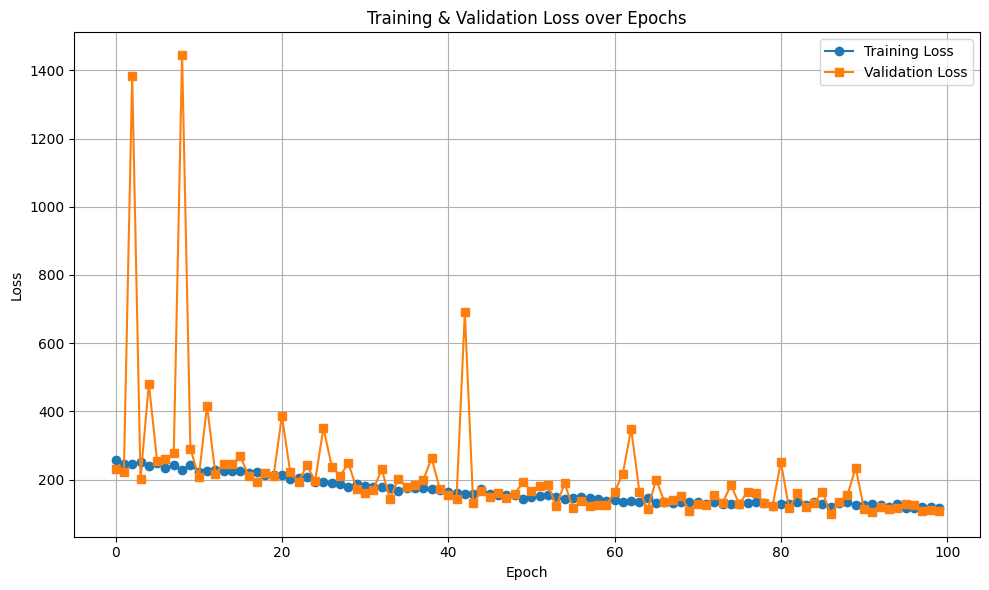

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for (atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx), target, _ in test_loader:
        atom_fea = atom_fea.to(device)
        nbr_fea = nbr_fea.to(device)
        nbr_fea_idx = nbr_fea_idx.to(device)
        target = target.to(device)

        output = model(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)
        all_preds.append(output.cpu().numpy())
        all_targets.append(target.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


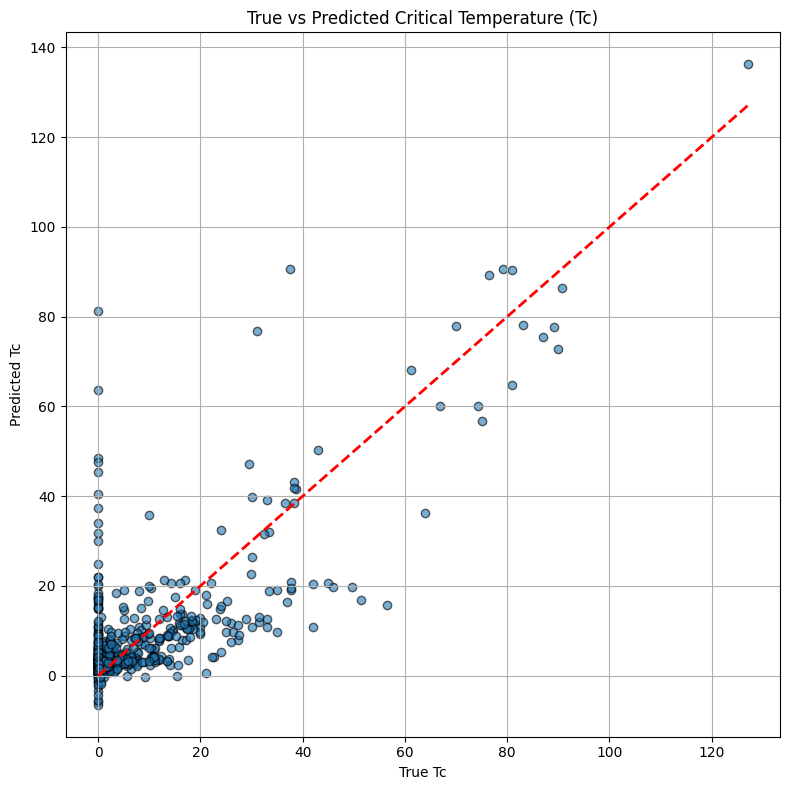

In [42]:
plt.figure(figsize=(8, 8))
plt.scatter(all_targets, all_preds, alpha=0.6, edgecolors='k')
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()], 'r--', lw=2)
plt.xlabel('True Tc')
plt.ylabel('Predicted Tc')
plt.title('True vs Predicted Critical Temperature (Tc)')
plt.grid(True)
plt.tight_layout()
plt.show()
